In [2]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

data_transform = transforms.ToTensor()
train_data = FashionMNIST(root='./FashionMNIST_data', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./FashionMNIST_data', train=False, download=True, transform=data_transform)

print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [4]:
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-6-2e4ed1b93c3b>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


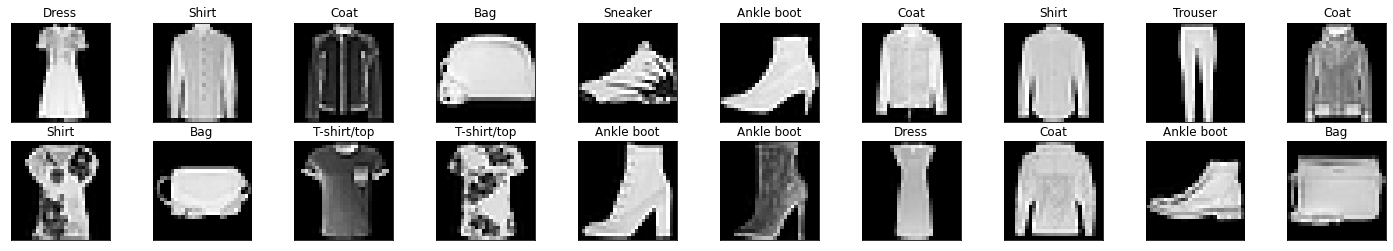

In [6]:
images, labels = next(iter(train_loader))
images = images.numpy()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [7]:
from torch import nn
from torch.nn import functional as F
from torch import optim

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1,10,3)
        self.pool = nn.MaxPool2d(2,2)  # maxpool layer pool with kernel_size=2, stride=2
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10,20,3)
        self.fc1 = nn.Linear(20*5*5, 50)
        # adding dropout with 0.04
        self.fc1_drop = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(50,10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        return x 
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [19]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
# Calculate accuracy before training
correct = 0
total = 0
'''with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()'''

for images, labels in test_loader:
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
accuracy = 100 * correct / total
print('Accuracy before training: ', accuracy)

Accuracy before training:  tensor(10.6700)


In [21]:
def train(n_epochs):
    loss_over_time = [] # to track the loss as the network trains
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [22]:
n_epochs = 30
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.6753069137334824
Epoch: 1, Batch: 2000, Avg. Loss: 0.9524513733088971
Epoch: 1, Batch: 3000, Avg. Loss: 0.8616139788329601
Epoch: 2, Batch: 1000, Avg. Loss: 0.7697218997180462
Epoch: 2, Batch: 2000, Avg. Loss: 0.7360656377971172
Epoch: 2, Batch: 3000, Avg. Loss: 0.6840121533721686
Epoch: 3, Batch: 1000, Avg. Loss: 0.6625814149379731
Epoch: 3, Batch: 2000, Avg. Loss: 0.6248255019783974
Epoch: 3, Batch: 3000, Avg. Loss: 0.6086410374343395
Epoch: 4, Batch: 1000, Avg. Loss: 0.5981911915242673
Epoch: 4, Batch: 2000, Avg. Loss: 0.5782324498742819
Epoch: 4, Batch: 3000, Avg. Loss: 0.5708902976959944
Epoch: 5, Batch: 1000, Avg. Loss: 0.546304978094995
Epoch: 5, Batch: 2000, Avg. Loss: 0.5445686594434083
Epoch: 5, Batch: 3000, Avg. Loss: 0.539209423944354
Epoch: 6, Batch: 1000, Avg. Loss: 0.528309110019356
Epoch: 6, Batch: 2000, Avg. Loss: 0.5204729546308517
Epoch: 6, Batch: 3000, Avg. Loss: 0.4990600953698158
Epoch: 7, Batch: 1000, Avg. Loss: 0.5003819677680

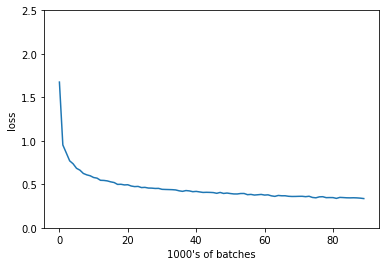

In [23]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [25]:
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
for batch_i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.339860

Test Accuracy of T-shirt/top: 89% (892/1000)
Test Accuracy of Trouser: 97% (971/1000)
Test Accuracy of Pullover: 83% (830/1000)
Test Accuracy of Dress: 86% (863/1000)
Test Accuracy of  Coat: 82% (824/1000)
Test Accuracy of Sandal: 95% (953/1000)
Test Accuracy of Shirt: 50% (504/1000)
Test Accuracy of Sneaker: 95% (951/1000)
Test Accuracy of   Bag: 98% (980/1000)
Test Accuracy of Ankle boot: 96% (968/1000)

Test Accuracy (Overall): 87% (8736/10000)


<ipython-input-26-2abde717b697>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])


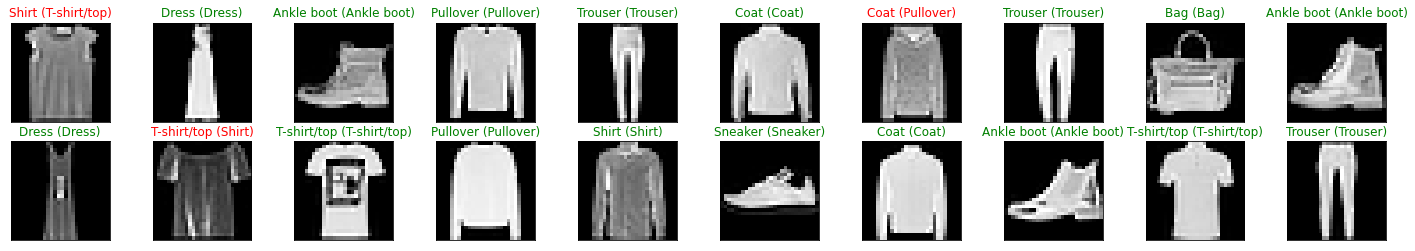

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [27]:
# Saving the model
model_dir = "../CNN layers and feature visualization/FashionMNIST_data/saved_models/"
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)